# Clustering

Most of the algorithms that we have discussed so far are what’s known as *supervised learning* algorithms,
in that they start with a set of labeled data and use that as the basis for making
predictions about new, unlabeled data.

Clustering, however, is an example of *unsupervised
learning*, in which we work with completely unlabeled data (or in which our
data has labels but we ignore them).

## The Idea

Whenever you look at some source of data, it’s likely that the data will somehow form
clusters.
- A dataset showing where millionaires live probably has clusters in places like Beverly Hills and Manhattan.
- A dataset showing how many hours people work each week probably has a cluster around 40 (and if it’s taken from a state with laws mandating special benefits for people who work at least 20 hours a week, it probably has another cluster right around 19).
- A dataset of demographics of registered voters likely forms a variety of clusters (e.g., “soccer moms,” “bored retirees,” “unemployed millennials”) that pollsters and political consultants consider relevant.

Unlike some of the problems we’ve looked at, there is generally no “correct” clustering.
- An alternative clustering scheme might group some of the “unemployed millennials” with “grad students,” and others with “parents’ basement dwellers.”

Neither scheme is necessarily more correct—instead, each is likely more optimal with respect
to its own “how good are the clusters?” metric.

Furthermore, the clusters won’t label themselves. You’ll have to do that by looking at
the data underlying each one.

## The Model

For us, each `input` will be a vector in *d*-dimensional space, which, as usual, we will
represent as a list of numbers. Our goal will be to identify clusters of similar inputs
and (sometimes) to find a representative value for each cluster.

For example, imagine that we have a
picture containing thousands of `(red, green, blue)` (RGB) colors and that we need to
screen-print a 10-color version of it. Clustering can help us choose 10 colors that will
minimize the total “color error.”

One of the simplest clustering methods is *k*-means, in which the number of clusters *k*
is chosen in advance, after which the goal is to partition the inputs into sets $S_1, \dots, S_k$
in a way that minimizes the total sum of squared distances from each point to the
mean of its assigned cluster.

There are a lot of ways to assign *n* points to *k* clusters, which means that finding an
optimal clustering is a very hard problem. We’ll settle for an iterative algorithm that
usually finds a good clustering:
1. Start with a set of *k*-means, which are points in *d*-dimensional space.
2. Assign each point to the mean to which it is closest.
3. If no point’s assignment has changed, stop and keep the clusters.
4. If some point’s assignment has changed (moving from one cluster to another), recompute the means and return to step 2.

To start with, we’ll create a helper function that measures how many coordinates two
vectors differ in. We’ll use this to track our training progress:

In [1]:
from typing import List
Vector = List[float]

def num_differences(v1: Vector, v2: Vector) -> int:
    assert len(v1) == len(v2)
    return len([x1 for x1, x2 in zip(v1, v2) if x1 != x2])

In [2]:
print(num_differences([1, 2, 3], [2, 1, 3]))
print(num_differences([1, 2], [1, 2]))

2
0


We also need a function that, given some vectors and their assignments to clusters,
computes the means of the clusters.

It may be the case that some cluster has no points assigned to it. We can’t take the mean of an empty collection, so in that case we’ll just
randomly pick one of the points to serve as the “mean” of that cluster:

In [3]:
import numpy as np

def cluster_means(k: int,
                  inputs: List[Vector],
                  assignments: List[int]) -> List[Vector]:
    
    # clusters[i] contains the inputs whose assignment is i
    clusters = [[] for i in range(k)]
    
    for input, assignment in zip(inputs, assignments):
        clusters[assignment].append(input)

    # if a cluster is empty, just use a random point
    # np.mean (..., axis = 0) will compute mean of vectors across axis 0 (rows)
    return [np.mean(cluster, axis = 0) if cluster else random.choice(inputs)
            for cluster in clusters]

And now we’re ready to code up our clusterer. As usual, we’ll use `tqdm` to track our
progress, but here we don’t know how many iterations it will take, so we then use
`itertools.count`, which creates an infinite iterable, and we’ll `return` out of it when
we’re done:

In [4]:
import itertools
import random
from tqdm.notebook import tqdm
from scipy.spatial import distance

class KMeans:
    def __init__(self, k: int) -> None:
        self.k = k                      # number of clusters
        self.means = None

    def classify(self, input: Vector) -> int:
        """return the index of the cluster closest to the input"""
        return min(range(self.k),
                   key=lambda i: distance.euclidean(input, self.means[i]))

    def train(self, inputs: List[Vector]) -> None:
        # Start with random assignments
        assignments = [random.randrange(self.k) for _ in inputs]

        with tqdm(itertools.count()) as t:
            for _ in t:
                # Compute means and find new assignments
                self.means = cluster_means(self.k, inputs, assignments)
                new_assignments = [self.classify(input) for input in inputs]

                # Check how many assignments changed and if we're done
                num_changed = num_differences(assignments, new_assignments)
                if num_changed == 0:
                    return

                # Otherwise keep the new assignments, and compute new means
                assignments = new_assignments
                self.means = cluster_means(self.k, inputs, assignments)
                t.set_description(f"changed: {num_changed} / {len(inputs)}")

Now let’s take a look at how this works.

## Example: Meetups

To celebrate the grow of your social network start-up company, your VP of User Rewards wants to organize
several in-person meetups for your hometown users, complete with beer, pizza, and t-shirts. You know the locations of all your local users 
and she’d like you to choose meetup locations that make it convenient for everyone to
attend.

![The locations of your hometown users](im/location.jpg)

Depending on how you look at it, you probably see two or three clusters. (It’s easy to
do visually because the data is only two-dimensional. With more dimensions, it
would be a lot harder to eyeball.)

Imagine first that she has enough budget for three meetups. You go to your computer
and try this:

In [5]:
inputs: List[List[float]] = [[-14,-5],[13,13],[20,23],[-19,-11],[-9,-16],[21,27],[-49,15],[26,13],[-46,5],[-34,-1],[11,15],[-49,0],[-22,-16],[19,28],[-12,-8],[-13,-19],[-41,8],[-11,-6],[-25,-9],[-18,-3]]

random.seed(12)                   # so you get the same results as me
clusterer = KMeans(k=3)
clusterer.train(inputs)

0it [00:00, ?it/s]

In [6]:
print(clusterer.means)

[array([-43.8,   5.4]), array([18.33333333, 19.83333333]), array([-15.88888889, -10.33333333])]


You find three clusters centered at [–44, 5], [–16, –10], and [18, 20], and you look for
meetup venues near those locations

![User locations grouped into three clusters](im/3_clusters.jpg)

You show your results to the VP, who informs you that now she only has enough
budgeted for two meetups.

“No problem,” you say:

In [7]:
random.seed(0)
clusterer = KMeans(k=2)
clusterer.train(inputs)

0it [00:00, ?it/s]

In [8]:
print(clusterer.means)

[array([18.33333333, 19.83333333]), array([-25.85714286,  -4.71428571])]


So now one meetup should still be near [18, 20], but now the other
should be near [–26, –5].

![User locations grouped into two clusters](im/2_clusters.jpg)

## Choosing k

In the previous example, the choice of *k* was driven by factors outside of our control.
In general, this won’t be the case. 

There are various ways to choose a *k*. One that’s
reasonably easy to understand involves plotting the sum of distances/errors (between
each point and the mean of its cluster) as a function of *k* and looking at where the
graph “bends”:

In [9]:
def sum_clustering_errors(inputs: List[Vector], k: int) -> float:
    """finds the total error from k-means clustering the inputs"""
    clusterer = KMeans(k)
    clusterer.train(inputs)
    means = clusterer.means
    assignments = [clusterer.classify(input) for input in inputs]

    return sum(distance.euclidean(input, means[cluster])
               for input, cluster in zip(inputs, assignments))

which we can apply to our previous example:

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

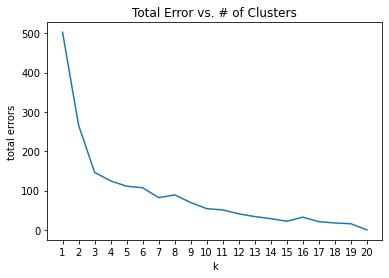

In [10]:
import matplotlib.pyplot as plt

# now plot from 1 up to len(inputs) clusters

ks = range(1, len(inputs) + 1)
errors = [sum_clustering_errors(inputs, k) for k in ks]

plt.plot(ks, errors)
plt.xticks(ks)
plt.xlabel("k")
plt.ylabel("total errors")
plt.title("Total Error vs. # of Clusters")
plt.show()

Judging by the figure, this method agrees with our original eyeballing that three is
the “right” number of clusters.

## Example: Clustering Colors

The VP of Swag has designed attractive stickers that he’d like you to
hand out at meetups. Unfortunately, your sticker printer can print at most five colors
per sticker. And since the VP of Art is on sabbatical, the VP of Swag asks if there’s
some way you can take his design and modify it so that it contains only five colors.

Computer images can be represented as two-dimensional arrays of pixels, where each
pixel is itself a three-dimensional vector `(red, green, blue)` indicating its color (note: sometimes there's a fourth dimension used to indicate the level of transparency, but we will not deal with it here).

Creating a five-color version of the image, then, entails:
1. Choosing five colors.
2. Assigning one of those colors to each pixel.

It turns out this is a great task for k-means clustering, which can partition the pixels
into five clusters in red-green-blue space. If we then recolor the pixels in each cluster
to the mean color, we’re done.

To start with, we’ll need a way to load an image into Python. We can do this with matplotlib,
if we first install the `pillow` library:

In [11]:
# pillow is pre-installed with Anaconda, so only manually install it if you did not install anaconda 
!python -m pip install pillow

Then we can just use `matplotlib.image.imread`:

In [12]:
image_path = "im/Uga_X.jpg"             # or wherever your image is
import matplotlib.image as mpimg
img = mpimg.imread(image_path) / 256    # rescale to between 0 and 1

FileNotFoundError: [Errno 2] No such file or directory: 'im/Uga_X.jpg'

The image we just loaded is one of Uga X. Of course, you could try other images as well.

![Uga_X](im/Uga_X.jpg)

Behind the scenes `img` is a NumPy array, but for our purposes, we can treat it as a 3-dimensional list.

In [ ]:
print(type(img))
print(img.shape)

`img[i][j]` is the pixel in the *i*th row and *j*th column, and each pixel is a list `[red, green, blue]` of numbers between 0 and 1 indicating the color of that pixel:

In [ ]:
top_row = img[0]
top_left_pixel = top_row[0]
red, green, blue = top_left_pixel

print(f"top row =\n{top_row}\n")
print(f"top_left_pixel = {top_left_pixel}")
print(f"red, green, blue = {red}, {green}, {blue}")

In particular, we can get a flattened list of all the pixels as:

In [ ]:
# .tolist() converts a numpy array to a Python list
pixels = [pixel.tolist() for row in img for pixel in row]

print(type(pixels))
print(len(pixels)) # 55000 = 275 * 200
print(pixels[0])

and then feed them to our clusterer:

In [ ]:
clusterer = KMeans(5)
clusterer.train(pixels)   # this might take a while

Once it finishes, we just construct a new image with the same format:

In [ ]:
def recolor(pixel: Vector) -> Vector:
    cluster = clusterer.classify(pixel)        # index of the closest cluster
    return clusterer.means[cluster]            # mean of the closest cluster

In [ ]:
new_img = [[recolor(pixel) for pixel in row]   # recolor this row of pixels
           for row in img]                     # for each row in the image

and display it, using `plt.imshow`:

In [ ]:
plt.rcParams['figure.figsize'] = (5, 5)

plt.imshow(new_img)
plt.axis('off')
plt.show()

## K-Means in scikit-learn

In [ ]:
# adapted from https://machinelearningmastery.com/clustering-algorithms-with-python/

# k-means clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

# generate an artificial dataset using numpy and then convert it to a dataframe
# when dealing with real datasets, you probably want to load the data via pd.read_csv() directly to obtain the dataframe
X, _ = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
X = pd.DataFrame(X, columns = ["column 0", "column 1"])

print(f"X = {X}")

# define the model
model = KMeans(n_clusters=2)

# fit the model
model.fit(X)

# assign a cluster to each example
yhat = model.predict(X)

print(f"yhat = {yhat}")

# retrieve unique clusters
clusters = unique(yhat)
print(f"clusters = {clusters}")

# create scatter plot for samples from each cluster
for cluster in clusters:
    # get sample rows that match the current cluster
    Xi = X[model.labels_ == cluster]
    
    print(f"Xi = {Xi}")
    
    # create scatter of these samples
    plt.scatter(Xi["column 0"], Xi["column 1"])
    
# show the plot
plt.show()

You can learn more about other types of clustering in:

https://scikit-learn.org/stable/modules/clustering.html

https://machinelearningmastery.com/clustering-algorithms-with-python/
